In [1]:
import sklearn
import hdbscan
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import sklearn.neighbors

from scipy.io import arff
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits import mplot3d
from sklearn import metrics

In [2]:
#Datasets pour KMEAN
good_data_kmean1 = arff.loadarff(open('datasets/artificial/R15.arff','r'))
good_data_kmean2 = arff.loadarff(open('datasets/artificial/diamond9.arff','r'))
good_data_kmean3 = arff.loadarff(open('datasets/artificial/spherical_4_3.arff','r')) 

bad_data_kmean1 = arff.loadarff(open('datasets/artificial/spiral.arff','r'))
bad_data_kmean2 = arff.loadarff(open('datasets/artificial/spiralsquare.arff','r'))
bad_data_kmean3 = arff.loadarff(open('datasets/artificial/complex9.arff','r')) 

#Datasets pour Agglomerative
good_data_agglo1 = arff.loadarff(open('datasets/artificial/zelnik3.arff','r'))
good_data_agglo2 = arff.loadarff(open('datasets/artificial/dartboard1.arff','r')) 
good_data_agglo3 = arff.loadarff(open('datasets/artificial/banana.arff','r'))

bad_data_agglo1 = arff.loadarff(open('datasets/artificial/disk-4500n.arff','r'))
bad_data_agglo2 = arff.loadarff(open('datasets/artificial/golfball.arff','r')) 
bad_data_agglo3 = arff.loadarff(open('datasets/artificial/atom.arff','r'))

#Datasets pour DBSCAN
good_data_DBSCAN1 = arff.loadarff(open('datasets/artificial/zelnik2.arff','r'))
good_data_DBSCAN2 = arff.loadarff(open('datasets/artificial/zelnik4.arff','r'))
good_data_DBSCAN3 = arff.loadarff(open('datasets/artificial/cure-t2-4k.arff','r'))

bad_data_DBSCAN1 = arff.loadarff(open('datasets/artificial/square4.arff','r'))
bad_data_DBSCAN2 = arff.loadarff(open('datasets/artificial/disk-1000n.arff','r'))
bad_data_DBSCAN3 = arff.loadarff(open('datasets/artificial/rings.arff','r'))

#Datasets pour comparaison DBSAN / HDBSCAN
comp_data_H_DB1 = arff.loadarff(open('datasets/artificial/square4.arff','r'))
comp_data_H_DB2 = arff.loadarff(open('datasets/artificial/disk-1000n.arff','r'))
comp_data_H_DB3 = arff.loadarff(open('datasets/artificial/rings.arff','r'))

mystery_data1 = [pd.read_csv('mistery_dataset/a.data', sep="\t")]
mystery_data2 = [pd.read_csv('mistery_dataset/h.data', sep="\t")]
mystery_data3 = [pd.read_csv('mistery_dataset/t.data', sep="\t")]
mystery_data4 = [pd.read_csv('mistery_dataset/tr.data', sep=" ")]
mystery_data5 = [pd.read_csv('mistery_dataset/zgn.data', sep=" ")]
mystery_data6 = [pd.read_csv('mistery_dataset/zgo1.data', sep=" ")]


In [3]:
### Definition des fonctions

def process_name(dataset, mystery = False):
    df = pd.DataFrame(dataset[0])
    if(mystery):
        return df
    list_name = df.iloc[:, -1]
    list_pre, list_post, compteur = [], [], 0
    for element in list_name:
        if element not in list_pre:
            list_pre.append(element)
            list_post.append(compteur)
            compteur+=1
    for i in range(len(list_pre)):
        df.iloc[:, -1] = list_name.replace(list_pre[i], list_post[i])
    return df

"""La fonction ci-dessous nous permet de récupérer les bons noms de colonnes des dataframe
car leurs noms peut changer entre les différents dataset"""

def init_df_cluster(df):
    return df[df.columns[0]], df[df.columns[1]] 

"""La fonction ci-dessous implémente la méthode des kmeans, pour une nombre maximum de 
cluster étant égal à max_clusters. La méthode retourne ensuite la valeur optimale de nombre de cluster
calculée par KMeans"""

def Kmeans(dataset, max_clusters = 20):
    
    list_kmeans, list_scores = [], []
    
    for i in range(2,max_clusters+1):
        kmeans = KMeans(n_clusters = i, random_state=0).fit(dataset)
        list_kmeans.append(kmeans)
        list_scores.append(np.mean(sklearn.metrics.silhouette_score(dataset, kmeans.labels_)))
    
    max_value = max(list_scores)
    return list_kmeans[list_scores.index(max_value)]


"""La fonction des kmeans ci-dessous propose une option permettant de s'arrêter lorsque l'amélioration
de l'inertie des clusters est inférieure à un certain pourcentage donné en paramètre. Par exemple, 
si l'inertie passe de 200 à 192, la fonction va retourner la clusterisation avec l'inertie de 192"""

def Kmeans_inertia(dataset, max_clusters = 20, pourcentage = 0.05):
    
    list_kmeans, list_scores, list_time = [], [], []
    timer = time.time()
    
    for i in range(1,max_clusters):
        
        kmeans = KMeans(n_clusters = i, random_state=0).fit(dataset)
        list_kmeans.append(kmeans)
        list_scores.append(kmeans.inertia_)
        list_time.append(round(time.time() - timer,4))

    best_cluster_number = len(list_scores)
    #plt.figure()
    #plt.plot(np.linspace(1,max_clusters - 1,max_clusters - 1), list_time)
    #plt.show()
    #print(list_time)
    print(f"Temps d'exécution inertia : {time.time() - timer}")

    for i in range(1, len(list_scores)):
        ecart = list_scores[i - 1] - list_scores[i] 
        if (ecart < list_scores[i - 1] * pourcentage):
            break
    return (list_kmeans[i-1])

"""La fonction ci-dessous implémente la méthode de clustering agglomératif, avec une option 'show_time'
permettant de plot le temps d'exécution en fonction du nombre de cluster choisi.
En abscisse, le nombre de cluster; en ordonnée, le temps de ms"""

def agglomerative(dataset, max_clusters = 20, show_time = False):
    
    list_X, list_scores = [], []
    timer = time.time()
    
    for i in range(2,max_clusters):
        clusters = AgglomerativeClustering(n_clusters=i).fit(dataset)
        list_X.append(clusters)
        list_scores.append(np.mean(sklearn.metrics.silhouette_samples(dataset,clusters.labels_)))
        max_value = max(list_scores)       
               
    print(f"Le temps d'exécution d'agglomerative est de : {time.time() - timer}")
    return list_X[list_scores.index(max_value)]

"""Cette fonction permet de plotter les clusters calculés par la méthode agglomerative sur un dataset donné
Si le paramètre time est à true, la fonction va retourner l'évolution du temps d'exécution des algorithmes
Pour les calculs sur les 6 données mystères, il faut mettre le paramètre 'mystery' à True pour que le process s'effectue
correctement"""

def plot_agglomerative(dataset, time = False, mystery = False, Three_Dim = False): 
    dataset = process_name(dataset, mystery)
    
    solution = agglomerative(dataset, show_time = time)

    X, Y = init_df_cluster(dataset)
    plt.figure()
    #plt.scatter(*zip(*dataset), c=solution.labels_)
    print(f"Score de la silhouette maximale : {np.mean(sklearn.metrics.silhouette_samples(dataset,solution.labels_))}")
    if(Three_Dim):
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = solution.labels_)
        plt.show()
    else:
        plt.scatter(X, Y, c = solution.labels_)
        plt.legend()
        plt.show()
    
def plot_clusters_kmeans(dataset, mystery = False):
    time_start = time.time()
    dataset = process_name(dataset, mystery)
    solution = Kmeans(dataset)

    X, Y = init_df_cluster(dataset)
    plt.scatter(X, Y, c = solution.labels_)
    plt.scatter(solution.cluster_centers_[:,0], solution.cluster_centers_[:,1], c='r', label = 'centers')
    plt.legend()
    print(f"Score de la silhouette: {np.mean(sklearn.metrics.silhouette_samples(dataset,solution.labels_))}")
    print(f"Le temps d'exécution est de : {time.time() - time_start}")
    
def plot_clusters_kmeans_inertia(dataset, mystery = False):
    data = process_name(dataset, mystery)
    solution = Kmeans_inertia(data)
    X, Y = init_df_cluster(data)
    plt.figure()
    plt.scatter(X, Y, c = solution.labels_)
    plt.scatter(solution.cluster_centers_[:,0], solution.cluster_centers_[:,1], c='r', label = 'centers')
    plt.legend()
    plt.show()
    print(f"Score de l'inertie : {solution.inertia_}")


def plot_clusters_kmeans3D(dataset, mystery = False):
    time_start = time.time()
    dataset = process_name(dataset, mystery)
    cluster = Kmeans(dataset)
    X, Y = init_df_cluster(dataset)
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = cluster.labels_)
    plt.legend()
    plt.show()
    print(f"Temps d'exécution de kmeans 3D : {time.time() - time_start}")
    print(f"Score de la silhouette : {np.mean(sklearn.metrics.silhouette_samples(dataset,cluster.labels_))}")
    
    
def plot_dbscan(dataset, eps_param = 0.5, min_samples_param = 10, mystery = False, Three_Dim = False):
    time_start = time.time()
    dataset = process_name(dataset, mystery)
    DBSCAN_result = DBSCAN(eps = eps_param, min_samples = min_samples_param).fit(dataset)
    print("Le temps d'exécution est de : {time.time() - time_start}")
    if(Three_Dim):
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = DBSCAN_result.labels_)
        plt.show()
    else:
        X, Y = init_df_cluster(dataset)
        plt.scatter(X,Y, c = DBSCAN_result.labels_)
    
def plot_dbscan_iteration(dataset, mystery = False, Three_Dim = False):
    time_start = time.time()
    
    dataset = process_name(dataset, mystery)
    X, Y = init_df_cluster(dataset)
    
    neighbor = NearestNeighbors(n_neighbors=4)
    nb_neighbors = neighbor.fit(dataset)

    distances, _ = nb_neighbors.kneighbors()
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    eps_init = np.median(distances) / 2
    eps = eps_init
    
    list_DBSCAN = []
    list_tuple, list_scores = [], []
    
    for i in range(0, 20):
        for samples in range(2,6):
            time_start = time.time()
            DBSCAN_result = DBSCAN(eps = eps, min_samples = samples).fit(dataset)
            list_DBSCAN.append(DBSCAN_result)
            try:
                list_scores.append(np.mean(sklearn.metrics.silhouette_samples(dataset,DBSCAN_result.labels_)))
                list_tuple.append((eps, samples))
            except:
                continue

            #print(f"Le temps d'exécution est de : {time.time() - time_start}")
            #print(DBSCAN_result.labels_)
            #print(metrics.silhouette_score(DBSCAN_result, DBSCAN_result.labels_)) <- voir bug
        eps += eps_init/2
        
    print(f"Temps d'exécution de dbscan par itérations : {time.time() - time_start}")    
    max_value = max(list_scores)
    best_index = list_scores.index(max_value)
    eps, samples = list_tuple[best_index]
    best_result = list_DBSCAN[best_index]
    print(f"Score de la silhouette maximale : {max_value}")
    if(Three_Dim):
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = best_result.labels_)
        plt.show()
    else:
        plt.figure()
        plt.scatter(X,Y, c = best_result.labels_)
        plt.xlabel(f"eps = {eps}, le nombre de samples est de {samples}")    
        plt.legend()
        plt.show()

    
def plot_hdbscan(dataset, mystery = False, Three_Dim = False):
    time_start = time.time()
    dataset = process_name(dataset, mystery)
    
    X, Y = init_df_cluster(dataset)
    list_scores, list_labels = [], []
    
    for cluster_size in range(2,10):
        clusterer = hdbscan.HDBSCAN(cluster_size)
        clusterer_labels = clusterer.fit_predict(dataset)
        list_scores.append(np.mean(sklearn.metrics.silhouette_samples(dataset,clusterer_labels)))
        list_labels.append(clusterer_labels)
        
    max_value = max(list_scores)
    best_cluster = list_scores[list_scores.index(max_value)]
    best_labels = list_labels[list_scores.index(max_value)]
    
    print(f"Temps d'exécution de hdbscan : {time.time() - time_start}")
    print(f"Score de la silhouette maximale : {max_value}")
    
    if(Three_Dim):
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.scatter3D(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = best_labels)
        plt.show()
    else:
        plt.figure()
        plt.scatter(X, Y, c = best_labels)
        plt.show()


KMEANS


No handles with labels found to put in legend.


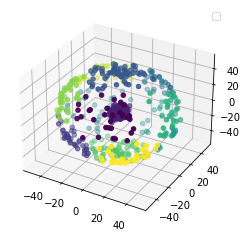

Temps d'exécution de kmeans 3D : 1.9189691543579102
Score de la silhouette : 0.6257573834313043
AGGLOMERATIVE
Le temps d'exécution d'agglomerative est de : 0.4289987087249756
Score de la silhouette maximale : 0.6011735718997894


<Figure size 432x288 with 0 Axes>

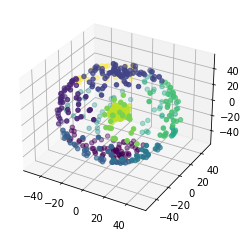

DBSCAN
Temps d'exécution de dbscan par itérations : 0.02099919319152832
Score de la silhouette maximale : 0.5203991941488649


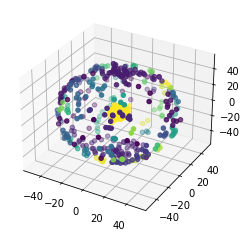

HDBSCAN
Temps d'exécution de hdbscan : 0.28499817848205566
Score de la silhouette maximale : 0.312174997631462


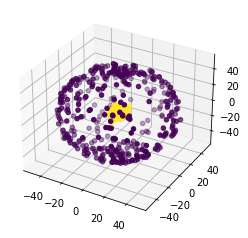

In [4]:
# Analyse des méthodes de clustering sur les datasets mystères

#Mistery1

print("KMEANS")
plot_clusters_kmeans3D(mystery_data1, mystery = True)
print("AGGLOMERATIVE")
plot_agglomerative(mystery_data1, mystery = True, Three_Dim = True)
print("DBSCAN")
plot_dbscan_iteration(mystery_data1, mystery = True, Three_Dim = True)
print("HDBSCAN")
plot_hdbscan(mystery_data1, mystery = True, Three_Dim = True)

KMEANS


No handles with labels found to put in legend.


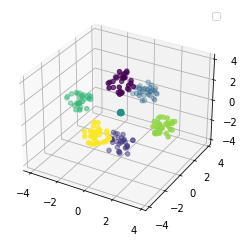

Temps d'exécution de kmeans 3D : 0.986208438873291
Score de la silhouette : 0.7006485323074687
AGGLOMERATIVE
Le temps d'exécution d'agglomerative est de : 0.09099769592285156
Score de la silhouette maximale : 0.7006485323074687


<Figure size 432x288 with 0 Axes>

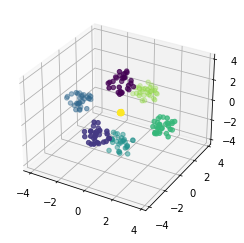

DBSCAN
Temps d'exécution de dbscan par itérations : 0.005017518997192383
Score de la silhouette maximale : 0.7006485323074687


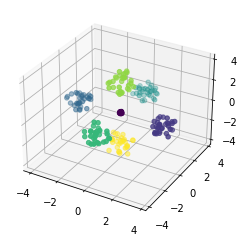

HDBSCAN
Temps d'exécution de hdbscan : 0.06699919700622559
Score de la silhouette maximale : 0.7006485323074687


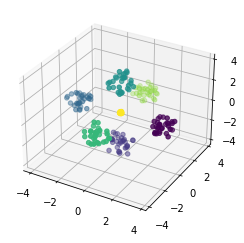

In [5]:
#Mistery2

print("KMEANS")
plot_clusters_kmeans3D(mystery_data2, mystery = True)
print("AGGLOMERATIVE")
plot_agglomerative(mystery_data2, mystery = True, Three_Dim = True)
print("DBSCAN")
plot_dbscan_iteration(mystery_data2, mystery = True, Three_Dim = True)
print("HDBSCAN")
plot_hdbscan(mystery_data2, mystery = True, Three_Dim = True)

KMEANS


No handles with labels found to put in legend.


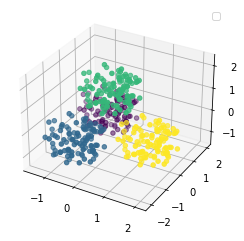

Temps d'exécution de kmeans 3D : 1.3250689506530762
Score de la silhouette : 0.5051896443563737
AGGLOMERATIVE
Le temps d'exécution d'agglomerative est de : 0.15399694442749023
Score de la silhouette maximale : 0.49457780725253114


<Figure size 432x288 with 0 Axes>

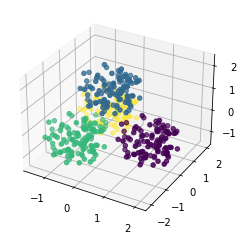

DBSCAN
Temps d'exécution de dbscan par itérations : 0.004997730255126953
Score de la silhouette maximale : 0.46915163298586127


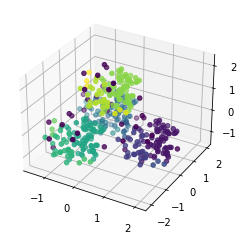

HDBSCAN
Temps d'exécution de hdbscan : 0.11999988555908203
Score de la silhouette maximale : 0.43980195119040366


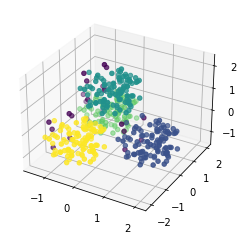

In [6]:
#Mistery3

print("KMEANS")
plot_clusters_kmeans3D(mystery_data3, mystery = True)
print("AGGLOMERATIVE")
plot_agglomerative(mystery_data3, mystery = True, Three_Dim = True)
print("DBSCAN")
plot_dbscan_iteration(mystery_data3, mystery = True, Three_Dim = True)
print("HDBSCAN")
plot_hdbscan(mystery_data3, mystery = True, Three_Dim = True)

KMEANS
Score de la silhouette: 0.6537654402893296
Le temps d'exécution est de : 31.941392421722412
AGGLOMERATIVE
Le temps d'exécution d'agglomerative est de : 65.46923542022705


No handles with labels found to put in legend.


Score de la silhouette maximale : 0.6538899954525795


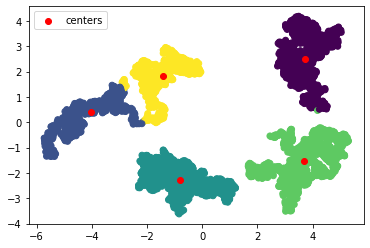

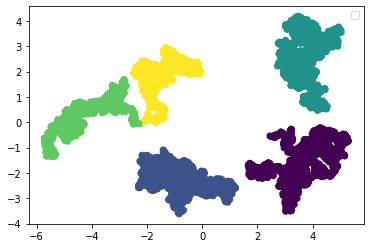

DBSCAN


No handles with labels found to put in legend.


Temps d'exécution de dbscan par itérations : 1.525740623474121
Score de la silhouette maximale : 0.6527831773958724


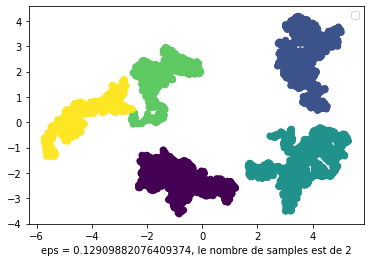

HDBSCAN
Temps d'exécution de hdbscan : 13.08398699760437
Score de la silhouette maximale : 0.6350128475135028


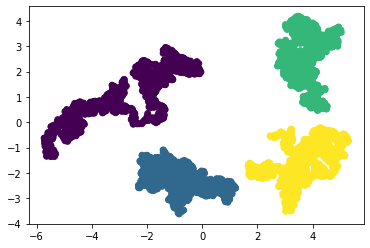

In [9]:
#Mistery4

print("KMEANS")
plot_clusters_kmeans(mystery_data4, mystery = True)
print("AGGLOMERATIVE")
plot_agglomerative(mystery_data4, mystery = True)
print("DBSCAN")
plot_dbscan_iteration(mystery_data4, mystery = True)
print("HDBSCAN")
plot_hdbscan(mystery_data4, mystery = True)

KMEANS


No handles with labels found to put in legend.


Score de la silhouette: 0.5923489694629451
Le temps d'exécution est de : 1.0429959297180176
AGGLOMERATIVE
Le temps d'exécution d'agglomerative est de : 0.12799835205078125
Score de la silhouette maximale : 0.5733923933145303


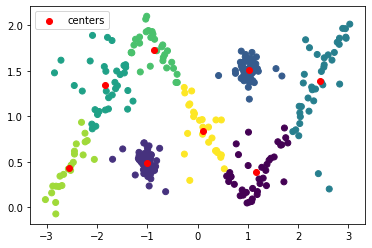

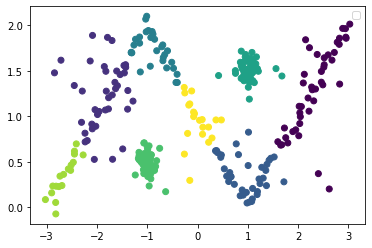

DBSCAN


No handles with labels found to put in legend.


Temps d'exécution de dbscan par itérations : 0.004999876022338867
Score de la silhouette maximale : 0.4194057122885528


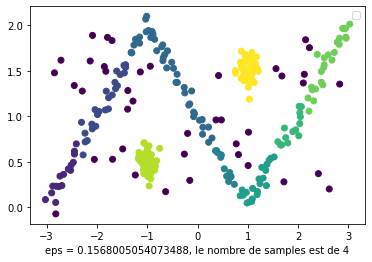

HDBSCAN
Temps d'exécution de hdbscan : 0.08599972724914551
Score de la silhouette maximale : 0.35782558808732934


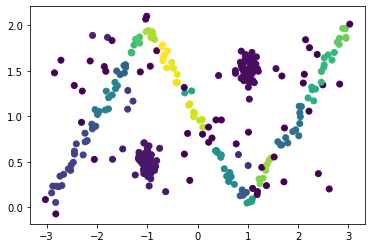

In [7]:
#Mistery5

print("KMEANS")
plot_clusters_kmeans(mystery_data5, mystery = True)
print("AGGLOMERATIVE")
plot_agglomerative(mystery_data5, mystery = True)
print("DBSCAN")
plot_dbscan_iteration(mystery_data5, mystery = True)
print("HDBSCAN")
plot_hdbscan(mystery_data5, mystery = True)

KMEANS


No handles with labels found to put in legend.


Score de la silhouette: 0.6882237336412494
Le temps d'exécution est de : 1.0080440044403076
AGGLOMERATIVE
Le temps d'exécution d'agglomerative est de : 0.1270008087158203
Score de la silhouette maximale : 0.6833267530735762


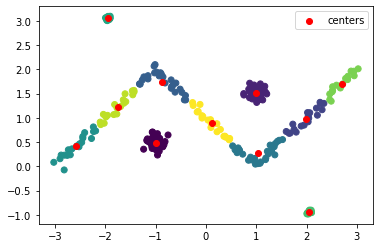

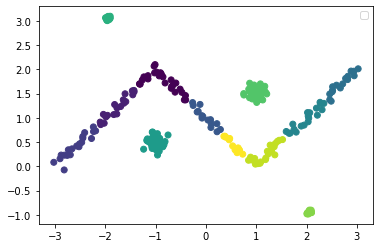

DBSCAN


No handles with labels found to put in legend.


Temps d'exécution de dbscan par itérations : 0.004999876022338867
Score de la silhouette maximale : 0.6248551404341494


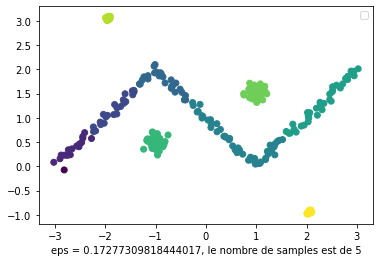

HDBSCAN
Temps d'exécution de hdbscan : 0.07299232482910156
Score de la silhouette maximale : 0.5426642586859961


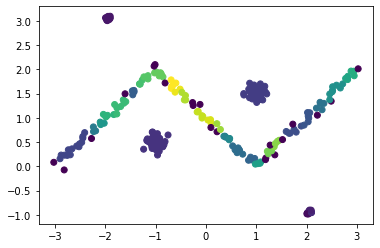

In [8]:
#Mistery6

print("KMEANS")
plot_clusters_kmeans(mystery_data6, mystery = True)
print("AGGLOMERATIVE")
plot_agglomerative(mystery_data6, mystery = True)
print("DBSCAN")
plot_dbscan_iteration(mystery_data6, mystery = True)
print("HDBSCAN")
plot_hdbscan(mystery_data6, mystery = True)